# Time Series Analysis of Nvidia Stock Price

### Cleaning Data

In [9]:
import pandas as pd
import os
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
file_path = r'C:\Users\phlc\OneDrive - Loughborough University\SS&C tasks\nvidia_stock_price.csv'  
df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

In [10]:
df['Price'].fillna(method='ffill', inplace=True) #forward fill data

In [65]:
df = df.resample('M').mean() #resample data to monthly

In [12]:
print(df)

                 Price        Open        High         Low
Date                                                      
2015-01-31    0.496667    0.503333    0.508333    0.491667
2015-02-28    0.535263    0.533684    0.538947    0.528947
2015-03-31    0.559545    0.560455    0.566818    0.553636
2015-04-30    0.553810    0.550476    0.557143    0.545714
2015-05-31    0.537000    0.535000    0.544000    0.531500
...                ...         ...         ...         ...
2024-05-31   96.220455   95.895455   97.528636   94.235455
2024-06-30  124.589474  124.546316  126.919474  121.756316
2024-07-31  121.912727  122.805000  124.889545  119.531364
2024-08-31  117.121818  116.824545  119.981364  113.578636
2024-09-30  112.619333  112.950667  115.407333  110.408667

[117 rows x 4 columns]


### Forward Filled Data 

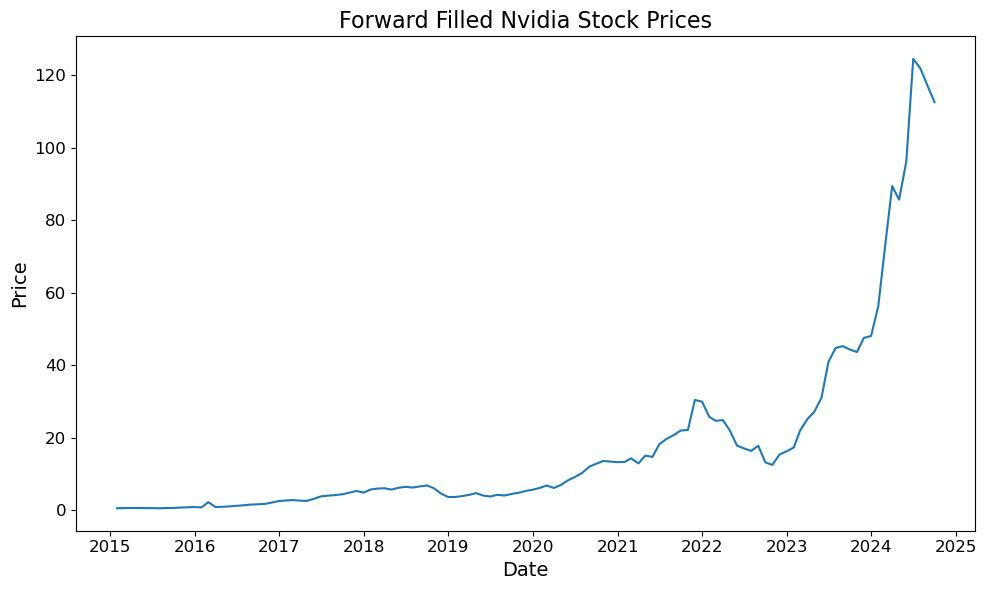

In [82]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(df['Price'])
plt.title('Forward Filled Nvidia Stock Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

### Distribution of Values 

In [16]:
print(df['Price'].describe())
print("Skewness", df['Price'].skew())
print("Kurtosis", df['Price'].kurt())


count    117.000000
mean      17.773980
std       26.517528
min        0.495000
25%        3.591579
50%        6.216667
75%       19.645714
max      124.589474
Name: Price, dtype: float64
Skewness 2.5933905784584175
Kurtosis 6.652490625706814


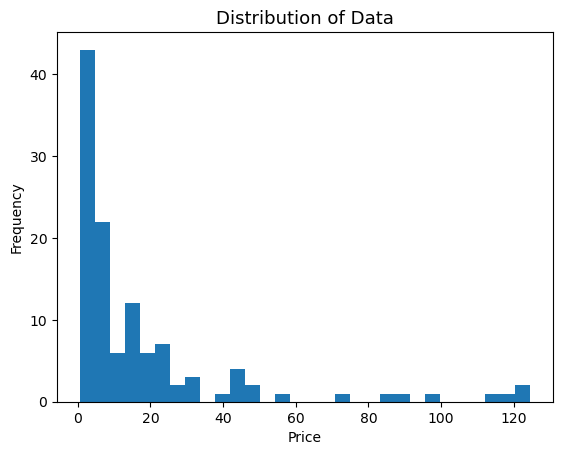

In [76]:
df['Price'].plot(kind='hist', bins=30) #plotting histogram 
plt.title('Distribution of Data', fontsize=13)
plt.xlabel('Price', fontsize=10)
plt.show()

### Time Series Decomposition 

<function matplotlib.pyplot.show(close=None, block=None)>

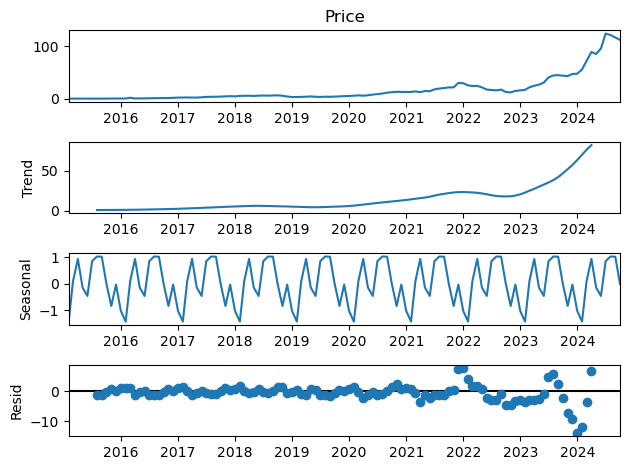

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Price'], model='additive') 
decomposition.plot()
plt.show

### Rolling Moving Average 

Text(0.5, 1.0, '12 Month Rolling Moving Average')

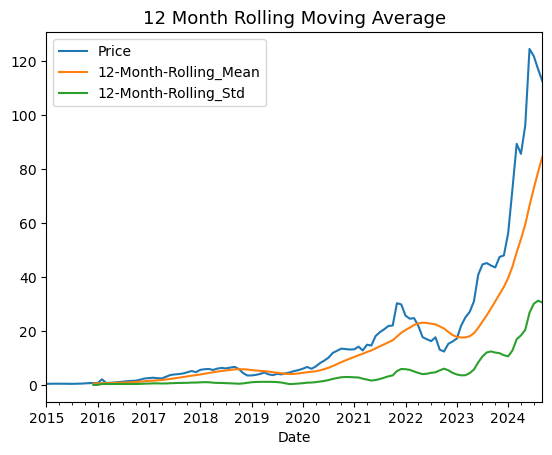

In [83]:
df['12-Month-Rolling_Mean'] = df['Price'].rolling(window=12).mean()
df['12-Month-Rolling_Std'] = df['Price'].rolling(window=12).std()
df[['Price', '12-Month-Rolling_Mean', '12-Month-Rolling_Std']].plot()
plt.title('12 Month Rolling Moving Average', fontsize=13)


### Stationarity Testing 

#### Stationarity of Raw Data - Augmented Dickey–Fuller Testing
Looking for a p-value of less than 0.05 to reject null hypothesis that that a unit root is present in a time series sample. 

In [87]:
from statsmodels.tsa.stattools import adfuller
data_test = adfuller(df['Price'].dropna())
print('p-value:', data_test[1])

p-value: 0.9948541836822619


#### Stationarity of Differenced Data 

In [86]:
#applying differencing to make data stationary 
df['Differenced'] = df['Price'].diff().dropna()
data_test2 = adfuller(df['Differenced'].dropna())
print('p-value:', data_test2[1])

p-value: 0.9740377679232931


#### Stationarity of Log-Transformed Data 

In [85]:
import numpy as np
df['Log_Price'] = np.log(df['Price'])
data_test3 = adfuller(df['Log_Price'].dropna())
print('p-value:', data_test3[1])

p-value: 0.9148922790495783


#### Stationarity of Log-Differenced Data 

In [84]:
import numpy as np
df['Log_Differenced'] = df['Log_Price'].diff().dropna()
data_test4 = adfuller(df['Log_Differenced'].dropna())
print('p-value:', data_test4[1])

p-value: 1.0766812570490461e-25


### Autocorrelation Functions 

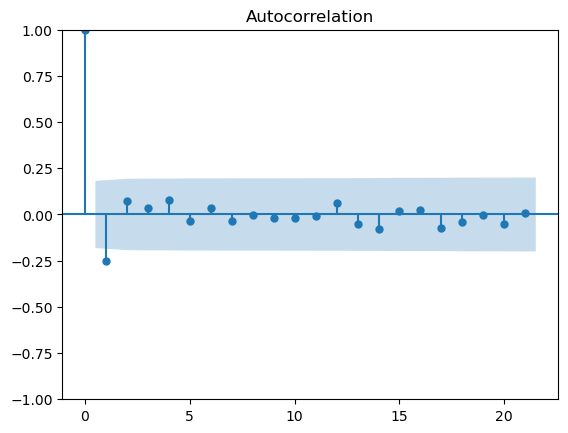

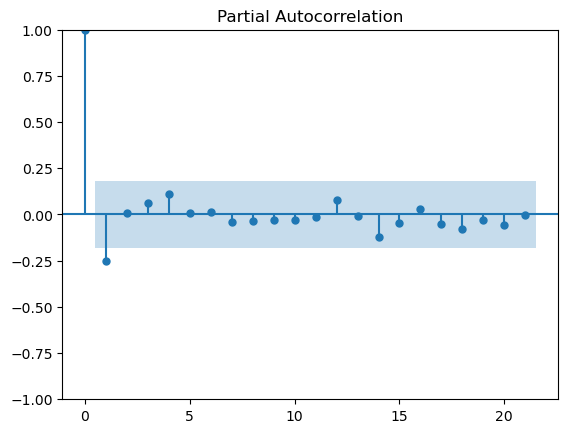

In [31]:
#Autocorrelation functions to determine q and p value for ARIMA model.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline
import matplotlib.pyplot as plt
plot_acf(df['Log_Differenced'].dropna()) #dropna makes sure null data points are not used
plot_pacf(df['Log_Differenced'].dropna())
plt.show()

### ARIMA Model 

                               SARIMAX Results                                
Dep. Variable:              Log_Price   No. Observations:                  117
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  39.704
Date:                Fri, 11 Oct 2024   AIC                            -69.409
Time:                        14:01:35   BIC                            -55.641
Sample:                    01-31-2015   HQIC                           -63.820
                         - 09-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8274      0.368      2.246      0.025       0.105       1.549
ar.L2          0.0452      0.366      0.124      0.902      -0.671       0.762
ma.L1         -1.0379      0.403     -2.574      0.0

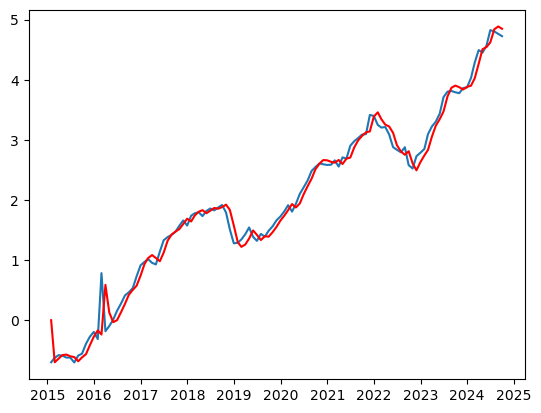

In [81]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df['Log_Price'].dropna(), order=(2,1,2)) 
model_fit = model.fit()
result = model.fit()

print(model_fit.summary())
plt.plot(df['Log_Price'])
plt.plot(model_fit.fittedvalues, color='red')

In [89]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = sqrt(mean_squared_error(df['Log_Price'], model_fit.fittedvalues))
print("RMSE", (mse))

RMSE 0.18275517520663023
